In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
small_model = 'qwen3_8b'
large_model = 'qwen3_32b'

## Hierarchical Routing

In [99]:
# Example 11: Analyze prompts from a file and get true token lengths
print("\n")
print("=" * 80)
print("ANALYZE PROMPTS FROM FILE")
print("=" * 80)

from router_system.compute_flops import reliability_cost_tradeoff_for_different_thresholds_hierarchical_routing
dataset = 'lmsys_chat1m_test'

if dataset == 'train.mmlu.test.gsm8k':
    file_path = './routing_dataset/datasets/gsm8k/gsm8k_train_qwen8b_correct_results.pkl'
    cpx_prob_dir = './cpx_model/inference_logs/Qwen8_train.MMLU_test.GSM8K.pkl'
    bert_prob_dir = './bert_routing/inference_logs/probabilities_20251215-164050.pkl'


elif dataset == 'mmlu_original_auxiliary_qwen8b':
    file_path = './routing_dataset/datasets/final_splits/mmlu_all_qwen8b_test.pkl'
    cpx_prob_dir = './cpx_model/inference_logs/Qwen_Qwen3-8B_20251210-200313.pkl'
    bert_prob_dir = './bert_routing/inference_logs/probabilities_20251211-101125.pkl'

elif dataset == 'mmlu_original_auxiliary_pro_gsm8k_qwen8b':
    file_path = './routing_dataset/datasets/final_splits/mmlu_all_pro_gsm8k_qwen8b_test.pkl'
    cpx_prob_dir = './cpx_model/inference_logs/Qwen_Qwen3-8B_20251217-094237.pkl'
    bert_prob_dir = './bert_routing/inference_logs/probabilities_20251221-144005.pkl'
    bert_base_prob_dir = './bert_routing/inference_logs/probabilities_20251224-132256.pkl'

elif dataset == 'hotpotqa_qwen8b_test_cleaned':
    file_path = './routing_dataset/datasets/hotpotqa/hotpotqa_qwen8b_test_cleaned.pkl'
    cpx_prob_dir = './cpx_model/inference_logs/Qwen_Qwen3-8B_20251223-115935.pkl'
    bert_prob_dir = './bert_routing/inference_logs/probabilities_20251222-131513.pkl'
    bert_base_prob_dir = './bert_routing/inference_logs/probabilities_20251224-114936.pkl'

elif dataset == 'apps_qwen8b_test':
    file_path = './routing_dataset/datasets/apps/apps_qwen8b_test.pkl'
    cpx_prob_dir = './cpx_model/inference_logs/Qwen_Qwen3-8B_20251230-121033.pkl'
    bert_prob_dir = None
    bert_base_prob_dir = './bert_routing/inference_logs/probabilities_20251230-180249.pkl'

elif dataset == 'lmsys_chat1m_test':
    file_path = './routing_dataset/datasets/lmsys_chat1m/lmsys_chat1m_test.pkl'
    cpx_prob_dir = './cpx_model/inference_logs/Qwen_Qwen3-8B_20260102-140121.pkl'
    bert_prob_dir = './bert_routing/inference_logs/probabilities_20260101-181437.pkl'
    bert_base_prob_dir = './bert_routing/inference_logs/probabilities_20260101-180751.pkl'

else:
    raise ValueError(f"Dataset {dataset} not found")



ANALYZE PROMPTS FROM FILE


## BERT only routing

In [100]:
from router_system.compute_flops import reliability_cost_tradeoff_for_different_thresholds_bert_routing

# Initialize variables to None/empty lists
bert_routing_tradeoff_results = None
bert_routing_costs = None
bert_routing_reliabilities = None
bert_routing_percantage_to_large_model = None
bert_routing_latencies = None
bert_routing_percentage_to_large_model = None

bert_base_routing_tradeoff_results = None
bert_base_routing_costs = None
bert_base_routing_reliabilities = None
bert_base_routing_percantage_to_large_model = None
bert_base_routing_latencies = None

if bert_prob_dir is not None:
    bert_routing_tradeoff_results = reliability_cost_tradeoff_for_different_thresholds_bert_routing(file_path, bert_prob_dir, small_model, large_model)
    bert_routing_costs = []
    bert_routing_reliabilities = []
    bert_routing_percantage_to_large_model = []
    bert_routing_latencies = []
    for comb in bert_routing_tradeoff_results:
        bert_routing_costs.append(bert_routing_tradeoff_results[comb]['flops'])
        bert_routing_reliabilities.append(bert_routing_tradeoff_results[comb]['reliability'])
        bert_routing_percantage_to_large_model.append(bert_routing_tradeoff_results[comb]['sent_to_large_model'] / bert_routing_tradeoff_results[comb]['total_count'])
        bert_routing_latencies.append(bert_routing_tradeoff_results[comb]['average_latency_per_prompt'])
    max_cost = max(bert_routing_costs)
    bert_routing_costs = [cost / 1e12 for cost in bert_routing_costs]

# bert base routing
if bert_base_prob_dir is not None:
    bert_base_routing_tradeoff_results = reliability_cost_tradeoff_for_different_thresholds_bert_routing(file_path, bert_base_prob_dir, small_model, large_model)
    bert_base_routing_costs = []
    bert_base_routing_reliabilities = []
    bert_base_routing_percantage_to_large_model = []
    bert_base_routing_latencies = []
    for comb in bert_base_routing_tradeoff_results:
        bert_base_routing_costs.append(bert_base_routing_tradeoff_results[comb]['flops'])
        bert_base_routing_reliabilities.append(bert_base_routing_tradeoff_results[comb]['reliability'])
        bert_base_routing_percantage_to_large_model.append(bert_base_routing_tradeoff_results[comb]['sent_to_large_model'] / bert_base_routing_tradeoff_results[comb]['total_count'] * 100)
        bert_base_routing_latencies.append(bert_base_routing_tradeoff_results[comb]['average_latency_per_prompt'])
    max_cost = max(bert_base_routing_costs)
    bert_base_routing_costs = [cost / 1e12 for cost in bert_base_routing_costs]

Computing FLOPs for different thresholds: 100%|██████████| 101/101 [00:00<00:00, 998.02it/s] 


## CPX only Routing TFOPs-Reliability

In [101]:
from router_system.compute_flops import reliability_cost_tradeoff_for_different_thresholds_cpx_routing

cpx_routing_tradeoff_results = reliability_cost_tradeoff_for_different_thresholds_cpx_routing(file_path, cpx_prob_dir, small_model, large_model)
cpx_routing_flops = []
cpx_routing_reliabilities = []
cpx_routing_percentage_to_large_model = []
cpx_routing_latencies = []
for comb in cpx_routing_tradeoff_results:
    cpx_routing_flops.append(cpx_routing_tradeoff_results[comb]['flops']/1e12)
    cpx_routing_reliabilities.append(cpx_routing_tradeoff_results[comb]['reliability'])
    cpx_routing_percentage_to_large_model.append((cpx_routing_tradeoff_results[comb]['sent_to_large_model'] / cpx_routing_tradeoff_results[comb]['total_count']) * 100)
    cpx_routing_latencies.append(cpx_routing_tradeoff_results[comb]['average_latency_per_prompt'])


Computing FLOPs for different thresholds: 100%|██████████| 101/101 [00:00<00:00, 863.48it/s]


## Plot both bert routing and hierarchical routing TFLOPs-Reliability

In [102]:
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from router_system.compute_flops import reliability_cost_tradeoff_for_different_thresholds_random_routing
import pickle

random_routing_tradeoff_results = reliability_cost_tradeoff_for_different_thresholds_random_routing(cpx_prob_dir, small_model, large_model)
random_routing_reliabilities = []
random_routing_latencies = []
random_routing_large_model_call_rate = []
for comb in random_routing_tradeoff_results:
    random_routing_reliabilities.append(random_routing_tradeoff_results[comb]['reliability'])
    random_routing_latencies.append(random_routing_tradeoff_results[comb]['average_latency_per_prompt'])
    random_routing_large_model_call_rate.append(random_routing_tradeoff_results[comb]['sent_to_large_model'] / random_routing_tradeoff_results[comb]['total_count'] * 100)

Computing reliability-cost tradeoff for random routing: 100%|██████████| 101/101 [00:00<00:00, 2550.70it/s]


## Plot both bert routing and hierarchical routing Latency-Reliability

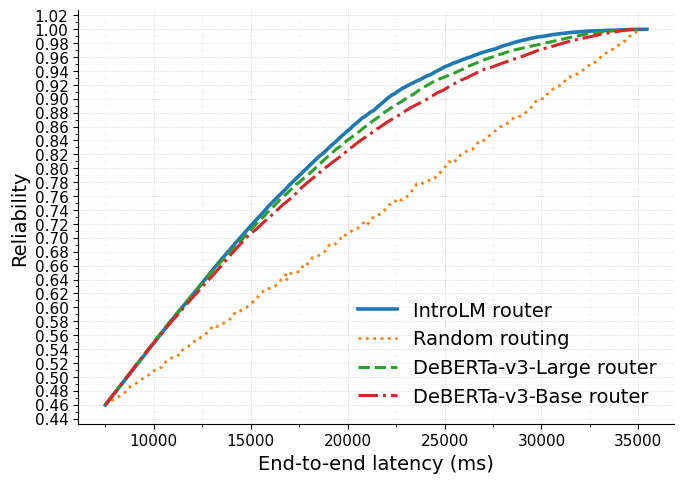

In [103]:
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import numpy as np

###
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# -----------------------
# Styling (paper-ready)
# -----------------------
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 14,   # slightly smaller to avoid covering curves
})

def sort_xy(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    idx = np.argsort(x)
    return x[idx], y[idx]

fig, ax = plt.subplots(figsize=(7, 5))

# Sort curves (important if x comes from threshold sweeps)
x_intro, y_intro = sort_xy(cpx_routing_latencies, cpx_routing_reliabilities)
x_rand,  y_rand  = sort_xy(random_routing_latencies, random_routing_reliabilities)

# Curves (grayscale-safe styles)
ax.plot(x_intro, y_intro, linestyle="-",  linewidth=2.6, label="IntroLM router")
ax.plot(x_rand,  y_rand,  linestyle=":",  linewidth=2.0, label="Random routing")

# Only plot BERT routing if available
if bert_routing_latencies is not None:
    x_large, y_large = sort_xy(bert_routing_latencies, bert_routing_reliabilities)
    ax.plot(x_large, y_large, linestyle="--", linewidth=2.2, label="DeBERTa-v3-Large router")

# Only plot BERT base routing if available
if bert_base_routing_latencies is not None:
    x_base,  y_base  = sort_xy(bert_base_routing_latencies, bert_base_routing_reliabilities)
    ax.plot(x_base,  y_base,  linestyle="-.", linewidth=2.2, label="DeBERTa-v3-Base router")

# Axes labels
ax.set_xlabel("End-to-end latency (ms)")
ax.set_ylabel("Reliability")

# Ticks / formatting
# X-axis: latency (ms)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5000))   # 5k ms
ax.xaxis.set_minor_locator(ticker.MultipleLocator(2500))   # 2.5k ms

# Format as "10k", "15k", ...
# ax.xaxis.set_major_formatter(
#     ticker.FuncFormatter(lambda x, _: f"{int(x/1000)}k")
# )

# Y-axis: reliability
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
# ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))

# Optional: focus y-range to highlight differences (use only if appropriate)
# ax.set_ylim(0.88, 1.00)

# Grid (light, non-distracting)
ax.grid(True, which="major", linestyle=":", linewidth=0.6, alpha=0.6)
ax.grid(True, which="minor", linestyle=":", linewidth=0.4, alpha=0.35)

# Remove top/right spines for a cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend (clean, avoids covering curves)
ax.legend(loc="lower right", frameon=False)

fig.tight_layout()
out_path = f"./figures/reliability_vs_latency_{dataset}.pdf"
fig.savefig(out_path, bbox_inches="tight")
plt.show()

#############################################

# Compute percentage improvement between hierarchical and BERT routing
# First, find the common reliability range
# min_reliability = max(
#     min(cpx_routing_reliabilities),
#     min(bert_routing_reliabilities)
# )
# max_reliability = min(
#     max(cpx_routing_reliabilities),
#     max(bert_routing_reliabilities)
# )

# # Create a common set of reliability values for interpolation
# common_reliabilities = np.linspace(min_reliability, max_reliability, 200)

# # Interpolate hierarchical routing latencies
# # Sort by reliability first to ensure monotonicity for interpolation
# hierarchical_sorted = sorted(zip(cpx_routing_reliabilities, 
#                                   cpx_routing_latencies))
# hierarchical_reliabilities_sorted = [r for r, _ in hierarchical_sorted]
# hierarchical_latencies_sorted = [l for _, l in hierarchical_sorted]

# bert_sorted = sorted(zip(bert_routing_reliabilities, bert_routing_latencies))
# bert_reliabilities_sorted = [r for r, _ in bert_sorted]
# bert_latencies_sorted = [l for _, l in bert_sorted]

# # Interpolate both curves
# hierarchical_interp = interp1d(hierarchical_reliabilities_sorted, hierarchical_latencies_sorted, 
#                                kind='linear', bounds_error=False, fill_value='extrapolate')
# bert_interp = interp1d(bert_reliabilities_sorted, bert_latencies_sorted, 
#                         kind='linear', bounds_error=False, fill_value='extrapolate')

# # Get interpolated latencies at common reliability values
# hierarchical_latencies_interp = hierarchical_interp(common_reliabilities)
# bert_latencies_interp = bert_interp(common_reliabilities)

# # Calculate percentage improvement: (bert - hierarchical) / bert * 100
# improvement_percentage = ((bert_latencies_interp - hierarchical_latencies_interp) / bert_latencies_interp) * 100

# # Filter out any invalid values (where bert_latency is 0 or negative)
# valid_mask = (bert_latencies_interp > 0) & np.isfinite(improvement_percentage)
# common_reliabilities_clean = common_reliabilities[valid_mask]
# improvement_percentage_clean = improvement_percentage[valid_mask]

# # Plot the improvement
# plt.figure(figsize=(10, 6))
# plt.plot(common_reliabilities_clean, improvement_percentage_clean, linewidth=2, color='green')
# plt.title('Latency Improvement: Hierarchical vs BERT Routing', fontsize=14)
# plt.xlabel('Reliability', fontsize=12)
# plt.ylabel('Latency Reduction (%)', fontsize=12)
# plt.grid(True, which="both", ls="--", color='gray', alpha=0.5)
# plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
# plt.fill_between(common_reliabilities_clean, 0, improvement_percentage_clean, 
#                  where=(improvement_percentage_clean >= 0), alpha=0.3, color='green', label='Improvement')
# plt.fill_between(common_reliabilities_clean, 0, improvement_percentage_clean, 
#                  where=(improvement_percentage_clean < 0), alpha=0.3, color='red', label='Degradation')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Print summary statistics
# print(f"Average improvement: {np.mean(improvement_percentage_clean):.2f}%")
# print(f"Max improvement: {np.max(improvement_percentage_clean):.2f}%")
# print(f"Min improvement: {np.min(improvement_percentage_clean):.2f}%")

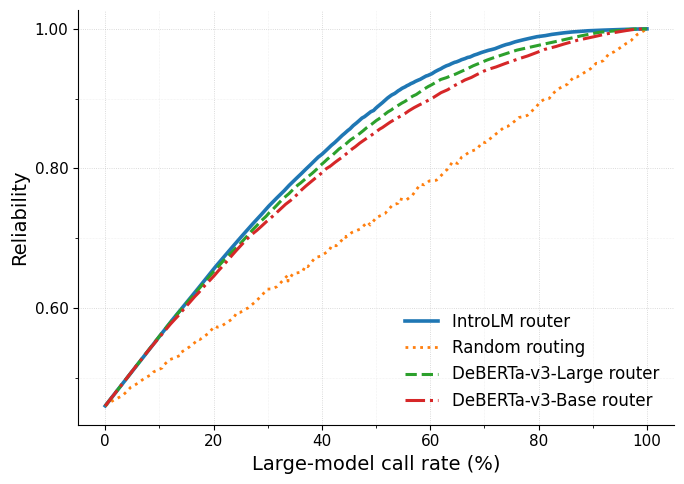

In [104]:


# Compute bert_routing_percentage_to_large_model if bert_routing_tradeoff_results is available
if bert_routing_tradeoff_results is not None:
    bert_routing_percentage_to_large_model = []
    for comb in bert_routing_tradeoff_results:
        bert_routing_percentage_to_large_model.append((bert_routing_tradeoff_results[comb]['sent_to_large_model'] / bert_routing_tradeoff_results[comb]['total_count']) * 100)
else:
    bert_routing_percentage_to_large_model = None
# plt.plot(pareto_front_hierarchical_routing_percentage_to_large_model, pareto_front_hierarchical_routing_reliabilities)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# -----------------------
# Styling (paper-ready)
# -----------------------
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 12,   # slightly smaller to avoid covering curves
})

def sort_xy(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    idx = np.argsort(x)
    return x[idx], y[idx]

fig, ax = plt.subplots(figsize=(7, 5))

# Sort curves (important if x comes from threshold sweeps)
x_intro, y_intro = sort_xy(cpx_routing_percentage_to_large_model, cpx_routing_reliabilities)
x_rand,  y_rand  = sort_xy(random_routing_large_model_call_rate, random_routing_reliabilities)

# Curves (grayscale-safe styles)
ax.plot(x_intro, y_intro, linestyle="-",  linewidth=2.6, label="IntroLM router")
ax.plot(x_rand,  y_rand,  linestyle=":",  linewidth=2.0, label="Random routing")

# Only plot BERT routing if available
if bert_routing_percentage_to_large_model is not None:
    x_large, y_large = sort_xy(bert_routing_percentage_to_large_model, bert_routing_reliabilities)
    ax.plot(x_large, y_large, linestyle="--", linewidth=2.2, label="DeBERTa-v3-Large router")

# Only plot BERT base routing if available
if bert_base_routing_percantage_to_large_model is not None:
    x_base,  y_base  = sort_xy(bert_base_routing_percantage_to_large_model, bert_base_routing_reliabilities)
    ax.plot(x_base,  y_base,  linestyle="-.", linewidth=2.2, label="DeBERTa-v3-Base router")

# Axes labels
ax.set_xlabel("Large-model call rate (%)")
ax.set_ylabel("Reliability")

# Ticks / formatting
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))

# Optional: focus y-range to highlight differences (use only if appropriate)
# ax.set_ylim(0.88, 1.00)

# Grid (light, non-distracting)
ax.grid(True, which="major", linestyle=":", linewidth=0.6, alpha=0.6)
ax.grid(True, which="minor", linestyle=":", linewidth=0.4, alpha=0.35)

# Remove top/right spines for a cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend (clean, avoids covering curves)
ax.legend(loc="lower right", frameon=False)

fig.tight_layout()
out_path = f"./figures/reliability_vs_callrate_{dataset}.pdf"
fig.savefig(out_path, bbox_inches="tight")
plt.show()

#############################################

# Compute percentage improvement in routing to the large model
# import numpy as np
# from scipy.interpolate import interp1d

# min_reliability_pct = max(
#     min(cpx_routing_reliabilities),
#     min(bert_routing_reliabilities)
# )
# max_reliability_pct = min(
#     max(cpx_routing_reliabilities),
#     max(bert_routing_reliabilities)
# )

# common_reliabilities_pct = np.linspace(min_reliability_pct, max_reliability_pct, 200)

# hierarchical_pct_sorted = sorted(zip(cpx_routing_reliabilities, 
#                                      cpx_routing_percentage_to_large_model))
# hierarchical_pct_reliabilities = [r for r, _ in hierarchical_pct_sorted]
# hierarchical_pct_values = [p for _, p in hierarchical_pct_sorted]

# bert_pct_sorted = sorted(zip(bert_routing_reliabilities, bert_routing_percentage_to_large_model))
# bert_pct_reliabilities = [r for r, _ in bert_pct_sorted]
# bert_pct_values = [p for _, p in bert_pct_sorted]

# hierarchical_pct_interp = interp1d(hierarchical_pct_reliabilities, hierarchical_pct_values, 
#                                    kind='linear', bounds_error=False, fill_value='extrapolate')
# bert_pct_interp = interp1d(bert_pct_reliabilities, bert_pct_values, 
#                            kind='linear', bounds_error=False, fill_value='extrapolate')

# hierarchical_pct_common = hierarchical_pct_interp(common_reliabilities_pct)
# bert_pct_common = bert_pct_interp(common_reliabilities_pct)

# # Improvement: reduction in percentage sent to large model
# improvement_pct_large = ((bert_pct_common - hierarchical_pct_common) / bert_pct_common) * 100

# valid_mask_pct = (bert_pct_common > 0) & np.isfinite(improvement_pct_large)
# common_reliabilities_pct_clean = common_reliabilities_pct[valid_mask_pct]
# improvement_pct_large_clean = improvement_pct_large[valid_mask_pct]

# plt.figure(figsize=(10, 6))
# plt.plot(common_reliabilities_pct_clean, improvement_pct_large_clean, linewidth=2, color='purple')
# plt.title('Reduction in Large-Model Usage: Hierarchical vs BERT', fontsize=14)
# plt.xlabel('Reliability', fontsize=12)
# plt.ylabel('Reduction in % Sent to Large Model', fontsize=12)
# plt.grid(True, which="both", ls="--", color='gray', alpha=0.5)
# plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
# plt.fill_between(common_reliabilities_pct_clean, 0, improvement_pct_large_clean, 
#                  where=(improvement_pct_large_clean >= 0), alpha=0.3, color='purple', label='Improvement')
# plt.fill_between(common_reliabilities_pct_clean, 0, improvement_pct_large_clean, 
#                  where=(improvement_pct_large_clean < 0), alpha=0.3, color='red', label='Degradation')
# plt.legend()
# plt.tight_layout()
# plt.show()

# print(f"Average reduction in larger-model usage: {np.mean(improvement_pct_large_clean):.2f}%")
# print(f"Max reduction: {np.max(improvement_pct_large_clean):.2f}%")
# print(f"Min reduction: {np.min(improvement_pct_large_clean):.2f}%")

ROC AUC for BERT routing: 0.862743200484011
PR AUC for BERT routing: 0.8351701639872232
PR AUC for BERT routing (neg): 0.8876083644796797
Brier score for BERT routing: 0.1664636046999661
ROC AUC for CPX routing: 0.9010716018045236
ROC AUC for BERT base routing: 0.8260958502375111
PR AUC for BERT base routing: 0.7876039447375829
PR AUC for BERT base routing (neg): 0.8571005909738587
PR AUC for CPX routing: 0.8845972183765787
PR AUC for CPX routing (neg): 0.9173123546975851
Brier score for CPX routing: 0.12966990506212722


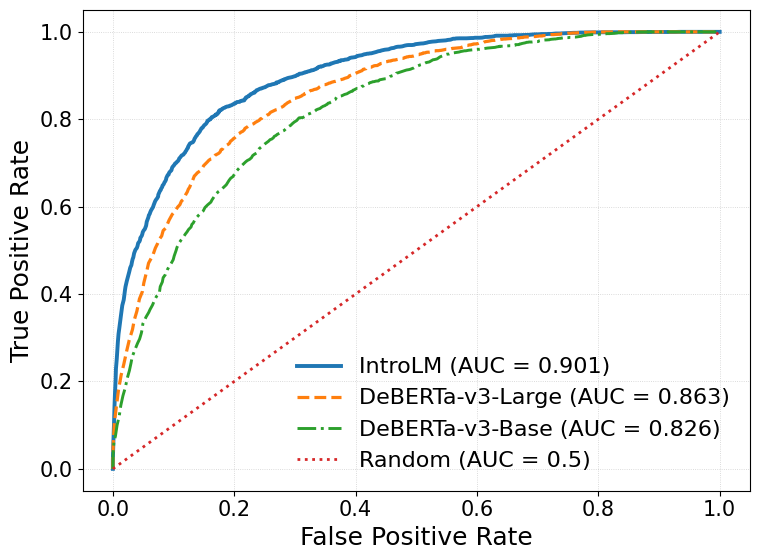

In [105]:
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score, precision_recall_curve, brier_score_loss
import pickle
import numpy as np

# Initialize BERT variables to None
bert_probabilities = None
fpr_bert = None
tpr_bert = None
roc_auc_bert = None
precision_bert = None
recall_bert = None
pr_auc_bert = None
precision_bert_neg = None
recall_bert_neg = None
pr_auc_bert_neg = None
brier_score_bert = None

bert_base_probabilities = None
fpr_bert_base = None
tpr_bert_base = None
roc_auc_bert_base = None
precision_bert_base = None
recall_bert_base = None
pr_auc_bert_base = None
precision_bert_base_neg = None
recall_bert_base_neg = None
pr_auc_bert_base_neg = None

# Get ROC curve for BERT routing (if available)
if bert_prob_dir is not None:
    with open(bert_prob_dir, 'rb') as f:
        bert_probabilities = pickle.load(f)
    
    fpr_bert, tpr_bert, thresholds_bert = roc_curve(bert_probabilities['labels'], bert_probabilities['probabilities'])
    roc_auc_bert = auc(fpr_bert, tpr_bert)
    print(f'ROC AUC for BERT routing: {roc_auc_bert}')
    
    # GET precision recall curve for BERT
    precision_bert, recall_bert, thresholds_bert = precision_recall_curve(bert_probabilities['labels'], bert_probabilities['probabilities'])
    precision_bert_neg, recall_bert_neg, thresholds_bert_neg = precision_recall_curve(1 - np.array(bert_probabilities['labels']), 1 - np.array(bert_probabilities['probabilities']))
    pr_auc_bert = auc(recall_bert, precision_bert)
    pr_auc_bert_neg = auc(recall_bert_neg, precision_bert_neg)
    brier_score_bert = brier_score_loss(bert_probabilities['labels'], bert_probabilities['probabilities'])
    print(f'PR AUC for BERT routing: {pr_auc_bert}')
    print(f'PR AUC for BERT routing (neg): {pr_auc_bert_neg}')
    print(f'Brier score for BERT routing: {brier_score_bert}')

# Get ROC curve for CPX routing
with open(cpx_prob_dir, 'rb') as f:
    cpx_probabilities = pickle.load(f)

fpr_cpx, tpr_cpx, thresholds_cpx = roc_curve(cpx_probabilities['labels'], cpx_probabilities['probabilities'])
roc_auc_cpx = auc(fpr_cpx, tpr_cpx)
print(f'ROC AUC for CPX routing: {roc_auc_cpx}')

# ROC curve for bert base routing (if available)
if bert_base_prob_dir is not None:
    with open(bert_base_prob_dir, 'rb') as f:
        bert_base_probabilities = pickle.load(f)
    
    fpr_bert_base, tpr_bert_base, thresholds_bert_base = roc_curve(bert_base_probabilities['labels'], bert_base_probabilities['probabilities'])
    roc_auc_bert_base = auc(fpr_bert_base, tpr_bert_base)
    print(f'ROC AUC for BERT base routing: {roc_auc_bert_base}')
    
    # get pr_auc for bert base routing
    precision_bert_base, recall_bert_base, thresholds_bert_base = precision_recall_curve(np.array(bert_base_probabilities['labels']), np.array(bert_base_probabilities['probabilities']))
    precision_bert_base_neg, recall_bert_base_neg, thresholds_bert_base_neg = precision_recall_curve(1 - np.array(bert_base_probabilities['labels']), 1 - np.array(bert_base_probabilities['probabilities']))
    pr_auc_bert_base = auc(recall_bert_base, precision_bert_base)
    pr_auc_bert_base_neg = auc(recall_bert_base_neg, precision_bert_base_neg)
    print(f'PR AUC for BERT base routing: {pr_auc_bert_base}')
    print(f'PR AUC for BERT base routing (neg): {pr_auc_bert_base_neg}')

# GET precision recall curve for CPX
precision_cpx, recall_cpx, thresholds_cpx = precision_recall_curve(cpx_probabilities['labels'], cpx_probabilities['probabilities'])
precision_cpx_neg, recall_cpx_neg, thresholds_cpx_neg = precision_recall_curve(1 - np.array(cpx_probabilities['labels']), 1 - np.array(cpx_probabilities['probabilities']))

# print pr_auc for CPX
pr_auc_cpx = auc(recall_cpx, precision_cpx)
pr_auc_cpx_neg = auc(recall_cpx_neg, precision_cpx_neg)
print(f'PR AUC for CPX routing: {pr_auc_cpx}')
print(f'PR AUC for CPX routing (neg): {pr_auc_cpx_neg}')

# get brier score for CPX
brier_score_cpx = brier_score_loss(cpx_probabilities['labels'], cpx_probabilities['probabilities'])
print(f'Brier score for CPX routing: {brier_score_cpx}')

#plot precision recall curve for all three models
# plt.figure(figsize=(10, 6))
# plt.plot(recall_bert, precision_bert, label=f'BERT (AUC = {roc_auc_bert:.2f})')
# plt.plot(recall_cpx, precision_cpx, label=f'CPX (AUC = {roc_auc_cpx:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('PositivePrecision-Recall Curve')
# plt.legend()
# plt.show()

# #plot negative precision recall curve for all three models
# plt.figure(figsize=(10, 6))
# plt.plot(recall_bert_neg, precision_bert_neg, label=f'BERT (AUC = {roc_auc_bert:.2f})')
# plt.plot(recall_cpx_neg, precision_cpx_neg, label=f'CPX (AUC = {roc_auc_cpx:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Negative Precision-Recall Curve')
# plt.legend()

import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 16,
})

plt.figure(figsize=(8, 6))

# IntroLM (highlighted)
plt.plot(
    fpr_cpx, tpr_cpx,
    linestyle='-',
    linewidth=2.8,
    color='#1f77b4',  # deep blue
    label=f'IntroLM (AUC = {roc_auc_cpx:.3f})'
)

# DeBERTa-v3-Large (only if available)
if fpr_bert is not None and tpr_bert is not None:
    plt.plot(
        fpr_bert, tpr_bert,
        linestyle='--',
        linewidth=2.3,
        color='#ff7f0e',  # muted orange
        label=f'DeBERTa-v3-Large (AUC = {roc_auc_bert:.3f})'
    )

# DeBERTa-v3-Base (only if available)
if fpr_bert_base is not None and tpr_bert_base is not None:
    plt.plot(
        fpr_bert_base, tpr_bert_base,
        linestyle='-.',
        linewidth=2.1,
        color='#2ca02c',  # green
        label=f'DeBERTa-v3-Base (AUC = {roc_auc_bert_base:.3f})'
    )

# Random router (from 0,0 to 1,1)
plt.plot(
    [0, 1], [0, 1],
    linestyle=':',
    linewidth=2.0,
    color='#d62728',  # red
    label=f'Random (AUC = {0.5})'
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc="lower right", frameon=False)
plt.grid(True, linestyle=':', linewidth=0.6, alpha=0.6)

output_file_path = f"./figures/roc_curve_{dataset}.pdf"
plt.tight_layout()
plt.savefig(output_file_path, bbox_inches="tight")
plt.show()

